In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.notebook import tqdm
from statistics import mean

import torchvision.transforms as transforms
import torch
import torch.nn.functional as F

from models.old_model import SiameseNetwork
from models.new_model import NewSiameseNetwork
from models import pretrained_model

from utils.other_utils import joinpath, TestNetworkDataset, get_dataset
from utils.other_utils import intersection, threshold

from embeddings.create_embeddings import create_embeddings
from embeddings.mean_embeddings import mean_embeddings

from scoring.test_report import test_report

In [38]:
# # Setup the path where images are located
# PATH = "/home/akshatgarg/Just-In-Time-Detection-of-Unknown-Classes-Using-Deep-Learning/data/brake shoe"

# # # save the model path
# MODEL_PATH = "/home/akshatgarg/Just-In-Time-Detection-of-Unknown-Classes-Using-Deep-Learning/saved_model/brake_shoe_model"

PATH = "data/RGBFace_no_background"

# # save the model path
MODEL_PATH = "saved_model/RGBFace_no_background_contrastive_1000_64_04_28_2023_15_43"

# Setup the number of channels in the image, 3 for color, 1 for monochrome
nchannel=3


# whether it is triplet or contrastive
FLAG = 'contrastive'
# FLAG = 'triplet'

# rotation flag
ROTATION = False

# if testing
testing = False

# Threshold score
THRESHOLD_SCORE = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    print(torch.cuda.get_device_name())
    torch.cuda.empty_cache()

In [39]:
# Resize the images and transform to tensors
if ROTATION:
    transformation = transforms.Compose([transforms.Resize((224,224)),
        transforms.ToTensor(), 
        transforms.RandomApply([
            transforms.RandomRotation([-30,30])], p = 0.2)
    ])
else:
    # transformation = transforms.Compose([transforms.Resize((100,100)),
    #                                  transforms.ToTensor()])
    transformation = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])] 
                                     )

In [40]:
# Getiing the saved model from MODEL_PATH

net = pretrained_model.SiameseNetwork().to(device)  # create an instance of your model class
# net = NewSiameseNetwork(3).to(device)
net.load_state_dict(torch.load(joinpath(MODEL_PATH,'model.pt')))
net.eval()

/home/akshatgarg/anaconda3/envs/torchcapstone/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/home/akshatgarg/anaconda3/envs/torchcapstone/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.



SiameseNetwork(
  (resnet18): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [ ]:
# # Save the trained model using pickle
# with open("trained_model.pkl", "wb") as f:
#     pickle.dump(net, f)

# # Load the saved model using pickle
# with open("trained_model.pkl", "rb") as f:
#     loaded_model = pickle.load(f)

# loaded_model.eval()  # Set

In [ ]:
# #### here we create dataiter for test

# # Locate the test dataset and load it into the SiameseNetworkDataset_for_test
# if testing:
#     test_dataloader,_ = get_dataset(joinpath(PATH,'test'), nchannel, transformation, TestNetworkDataset, FLAG, 0, 1, True)

#     # Grab one image that we are going to test
#     dataiter = iter(test_dataloader)
#     x0,_ = next(dataiter)


#     #### here we create dataiter for train.

#     # Locate the test dataset and load it into the SiameseNetworkDataset_for_test
#     train_dataloader,siamese_dataset_train = get_dataset(joinpath(PATH,'train'), nchannel, transformation, TestNetworkDataset, FLAG, 0, 1, False)

#     dataiter_train = iter(train_dataloader)

#     score = []

#     for i in range(len(siamese_dataset_train)):
#         # Iterate over all images and test them with the first image (x0)
#         x1,_ = next(dataiter_train)

#         # Concatenate the two images together
#         concatenated = torch.cat((x0, x1), 0)
        
#         output1, output2 = net(x0.cto(device), x1.to(device))
#         euclidean_distance = F.pairwise_distance(output1, output2)
#         score.append(round(euclidean_distance.item(),2))
#         imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')
#         # cosine_distance = torch.cosine_similarity(output1, output2)
#         # score.append(round(cosine_distance.item(),2))
#         # imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {cosine_distance.item():.2f}')

In [ ]:
#### here we create dataiter for test

test_dataloader,siamese_dataset = get_dataset(joinpath(PATH,'test'), nchannel, transformation, TestNetworkDataset, FLAG, 0, 1, True)

#### here we create dataiter for train

train_dataloader,siamese_dataset_train = get_dataset(joinpath(PATH,'train'), nchannel, transformation, TestNetworkDataset, FLAG, 0, 1, False)


truth=[]
predict=[]
same_disssimilarity=[]
different_disssimilarity=[]


dataiter = iter(test_dataloader)
for i in tqdm(range(len(siamese_dataset)),desc='TestCount'):
    
    x0,label0 = next(dataiter)
    # count_label0.append(label0)
    

# Grab one image that we are going to test
    dataiter_train = iter(train_dataloader)

    for i in range(len(siamese_dataset_train)):
    # Iterate over 5 images and test them with the first image (x0)
        x1,label1 = next(dataiter_train)
        # count_label1.append(label1)

        # Concatenate the two images together
        concatenated = torch.cat((x0, x1), 0)

        output1, output2 = net(x0.to(device), x1.to(device))
        euclidean_distance = F.pairwise_distance(output1, output2)
        

        predict.append(euclidean_distance.item())
        if label0==label1: # if labels of two images are same append them to same_dissimilar
            same_disssimilarity.append(euclidean_distance.item())
        else:
            different_disssimilarity.append(euclidean_distance.item())

        # cosine_distance = torch.cosine_similarity(output1, output2)
        # predict.append(cosine_distance.item())
        # if label0==label1:
        #     same_disssimilarity.append(cosine_distance.item())
        # else:
        #     different_disssimilarity.append(cosine_distance.item())

In [ ]:
# checking if there are any intersection in same and different images
print("Number of total interesection: ", len(intersection(same_disssimilarity,different_disssimilarity)))

In [ ]:
import pickle

# open a file in binary write mode
with open(joinpath(MODEL_PATH,'disssimilarity_lists.pkl'), 'wb') as f:
    # pickle the two lists
    pickle.dump(same_disssimilarity, f)
    pickle.dump(different_disssimilarity, f)


In [5]:
import pickle

# open the file in binary read mode
with open(joinpath(MODEL_PATH,'disssimilarity_lists.pkl'), 'rb') as f:
    # unpickle the two lists
    same_disssimilarity = pickle.load(f)
    different_disssimilarity = pickle.load(f)

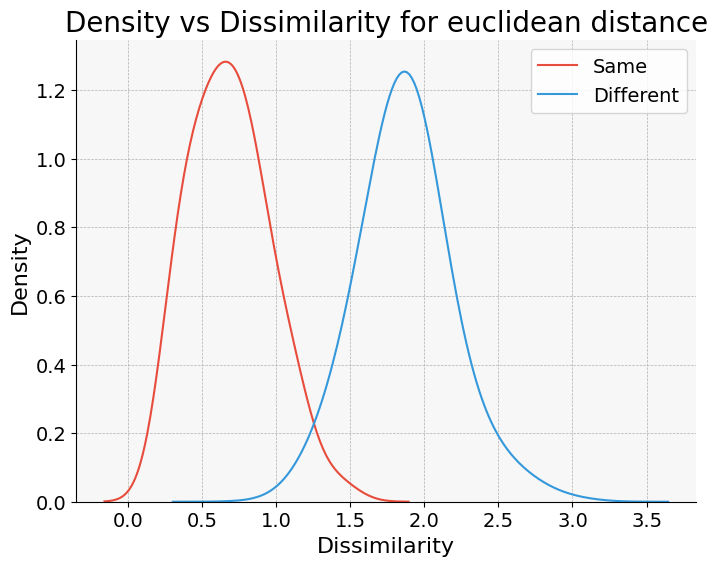

In [6]:
# Create figure and axes objects
fig, ax = plt.subplots(figsize=(8, 6))

# Set custom color palette
colors = ["#E74C3C", "#3498DB"]

# Set background color
ax.set_facecolor("#F7F7F7")

# Plot the distributions and set custom colors
sns.kdeplot(same_disssimilarity, bw_method=0.5, label="Same", color=colors[0])
sns.kdeplot(different_disssimilarity, bw_method=0.5, label="Different", color=colors[1])

# Add legend and title
plt.legend(fontsize=14)
plt.title('Density vs Dissimilarity for euclidean distance', fontsize=20)

# Add gridlines
ax.grid(linestyle='--', linewidth=0.5)

# Set axis labels and tick sizes
plt.xlabel("Dissimilarity", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Remove top and right spines
sns.despine(top=True, right=True)

plt.show()


In [7]:
import plotly.figure_factory as ff
import numpy as np

x1 = same_disssimilarity
x2 = different_disssimilarity

hist_data = [x1, x2]

group_labels = ["Same", "Different"]
# colors = ['#333F44', '#37AA9C']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, bin_size=0.15, show_hist=True, curve_type='kde')

# Add title
fig.update_layout(title_text='Curve and Rug Plot')
fig.show()

In [8]:
# checking for mean/average score
print("Mean of same images: ",mean(same_disssimilarity))
print("Mean of different images: ",mean(different_disssimilarity))

Mean of same images:  0.6878657366999072
Mean of different images:  1.8730256005036852


In [9]:
# Prinitng total number of combinations that we tested on
print("Total number of combinations of same images: ", len(same_disssimilarity))
print("Total number of combinations of different images: ", len(different_disssimilarity))
print("Total number of combinations: ", len(same_disssimilarity) + len(different_disssimilarity))

Total number of combinations of same images:  3296
Total number of combinations of different images:  36704
Total number of combinations:  40000


In [10]:
# Checking for number of missclassified images
final_list, same_misclassified, different_misclassified = threshold(same_disssimilarity,different_disssimilarity,THRESHOLD_SCORE)

print("Total number of missclassified for threshold score ",THRESHOLD_SCORE," missclassified images: ",len(final_list))
print("Total number of same class missclassified for threshold score ",THRESHOLD_SCORE," missclassified images: ",len(same_misclassified))
print("Total number of different class missclassified for threshold score ",THRESHOLD_SCORE," missclassified images: ",len(different_misclassified))

Total number of missclassified for threshold score  1  missclassified images:  474
Total number of same class missclassified for threshold score  1  missclassified images:  442
Total number of different class missclassified for threshold score  1  missclassified images:  32


In [11]:
embedding_dataloader, embedding_dataset = get_dataset(joinpath(PATH,'train'), nchannel, transformation, TestNetworkDataset, FLAG, 0, 1, False)

dict_embeddings = create_embeddings(net, device, embedding_dataloader, embedding_dataset)
dict_mean = mean_embeddings(dict_embeddings)

In [ ]:
import pickle

# open a file in binary write mode
with open(joinpath(MODEL_PATH,'mean_dict.pkl'), 'wb') as f:
    # pickle the two lists
    pickle.dump(dict_mean, f)


In [12]:
from embeddings.extract_labels_embeddings import extract_labels_and_embeddings
embeddings, labels = extract_labels_and_embeddings(dict_embeddings)
# embeddings

In [33]:
test_dataloader, test_dataset = get_dataset(joinpath(PATH,'test'), nchannel, transformation, 
                                            TestNetworkDataset, FLAG, 0, 1, False)
dataiter = iter(test_dataloader)

img,_ = next(dataiter)

print(img)


tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ...,  0.9817,  1.0502,  1.1187],
          [-2.1179, -2.1179, -2.1179,  ...,  1.3927,  1.4954,  1.4954],
          [-2.1179, -2.1179, -2.1179,  ...,  1.6153,  1.5125,  1.4269]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ...,  0.2927,  0.4503,  0.5728],
          [-2.0357, -2.0357, -2.0357,  ...,  1.0280,  1.2031,  1.2381],
          [-2.0357, -2.0357, -2.0357,  ...,  1.3957,  1.3606,  1.3081]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044, -

In [13]:
test_dataloader, test_dataset = get_dataset(joinpath(PATH,'test'), nchannel, transformation, 
                                            TestNetworkDataset, FLAG, 0, 1, False)

report, execution_time, avg_time_image,cm = test_report(PATH, net, device, test_dataloader, test_dataset, dict_embeddings, THRESHOLD_SCORE, 'base', 10)

  0%|          | 0/125 [00:00<?, ?it/s]

In [14]:
print(report)
print("Execution time per image: ", mean(avg_time_image), " seconds")
print("Execution time: ", execution_time, " seconds")

               precision    recall  f1-score   support

Unknown Class       0.66      0.95      0.78        22
      class_1       1.00      1.00      1.00        10
     class_10       1.00      0.90      0.95        10
      class_2       1.00      0.82      0.90        11
      class_3       1.00      0.90      0.95        10
      class_4       1.00      1.00      1.00        11
      class_5       1.00      0.60      0.75        10
      class_6       0.90      0.82      0.86        11
      class_7       1.00      0.90      0.95        10
      class_8       1.00      1.00      1.00        11
      class_9       1.00      1.00      1.00         9

     accuracy                           0.90       125
    macro avg       0.96      0.90      0.92       125
 weighted avg       0.93      0.90      0.91       125

Execution time per image:  0.01201767921447754  seconds
Execution time:  1.5288166999816895  seconds


In [15]:
print(cm)

[['Unknown Class' 'class_1' 'class_10' 'class_2' 'class_3' 'class_4'
  'class_5' 'class_6' 'class_7' 'class_8' 'class_9']
 ['21' '0' '0' '0' '0' '0' '0' '1' '0' '0' '0']
 ['0' '10' '0' '0' '0' '0' '0' '0' '0' '0' '0']
 ['1' '0' '9' '0' '0' '0' '0' '0' '0' '0' '0']
 ['2' '0' '0' '9' '0' '0' '0' '0' '0' '0' '0']
 ['1' '0' '0' '0' '9' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '11' '0' '0' '0' '0' '0']
 ['4' '0' '0' '0' '0' '0' '6' '0' '0' '0' '0']
 ['2' '0' '0' '0' '0' '0' '0' '9' '0' '0' '0']
 ['1' '0' '0' '0' '0' '0' '0' '0' '9' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0' '0' '11' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '9']]


In [16]:
test_dataloader, test_dataset = get_dataset(joinpath(PATH,'test'), nchannel, transformation, 
                                            TestNetworkDataset, FLAG, 0, 1, False)

report, execution_time, avg_time_image, cm = test_report(PATH, net, device, test_dataloader, test_dataset, dict_embeddings, THRESHOLD_SCORE, 'all', 10)

  0%|          | 0/125 [00:00<?, ?it/s]

In [17]:
print(report)
print("Execution time per image: ", mean(avg_time_image), " seconds")
print("Execution time: ", execution_time, " seconds")

               precision    recall  f1-score   support

Unknown Class       0.66      0.95      0.78        22
      class_1       1.00      1.00      1.00        10
     class_10       1.00      0.90      0.95        10
      class_2       1.00      0.82      0.90        11
      class_3       1.00      0.90      0.95        10
      class_4       1.00      1.00      1.00        11
      class_5       1.00      0.60      0.75        10
      class_6       0.90      0.82      0.86        11
      class_7       1.00      0.90      0.95        10
      class_8       1.00      1.00      1.00        11
      class_9       1.00      1.00      1.00         9

     accuracy                           0.90       125
    macro avg       0.96      0.90      0.92       125
 weighted avg       0.93      0.90      0.91       125

Execution time per image:  0.01784840774536133  seconds
Execution time:  2.264477491378784  seconds


In [18]:
# test_dataloader, test_dataset = get_dataset(joinpath(PATH,'test'), transformation, TestNetworkDataset, FLAG, 0, 1, False)
# dataiter = iter(test_dataloader)
# image, label = next(dataiter)

# print(label[0])
# n_way_dict = n_way_shot_learning(net, device, image, dict_mean, THRESHOLD_SCORE)
# print(n_way_dict)

In [19]:
my_list = [round(x * 0.01, 2) for x in range(-300, 301)]
final = []
same = []
different = []
for i in my_list:
    a,b,c = threshold(same_disssimilarity,different_disssimilarity,i)
    final.append(len(a))
    same.append(len(b))
    different.append(len(c))

In [20]:
import plotly.express as px

# create the line plot
fig = px.line(x=my_list, y=final)

# set the x-axis range to -1 to 1 and y-axis range to -100 to 2500
fig.update_xaxes(range=[-1, 2])
fig.update_yaxes(range=[-100, 5000])

# add a vertical line at x=0.2
fig.add_shape(type='line', x0=0.2, x1=0.2,
              y0=0, y1=max(final),
              line=dict(color='red', width=1, dash='dash'),
              name='Minimum Number of Misclassification')

fig.update_layout(
    title={
        'text': 'Total missclassification vs threshold',
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis_title='Threshold',
    yaxis_title='Missclassified images',
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='DarkGray', linecolor='DarkGray', linewidth=2),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='DarkGray', linecolor='DarkGray', linewidth=2),
    showlegend=True
)
# display the plot
fig.show()

In [21]:
import plotly.graph_objects as go

# create trace for the first line
trace1 = go.Scatter(x=my_list, y=same, mode='lines', name='<b>Same class Images</b>', line=dict(color='red', width=3))

# create trace for the second line
trace2 = go.Scatter(x=my_list, y=different, mode='lines', name='<b>Different class Images</b>', line=dict(color='blue', width=3))

# create the figure object and add both traces
fig = go.Figure()
fig.add_trace(trace1)
fig.add_trace(trace2)

# set the x-axis range to -1 to 1 and y-axis range to -100 to 2500
fig.update_xaxes(range=[0, 2])
fig.update_yaxes(range=[-100, 25000])

# find the intersection point of the two lines
intersection_point = my_list[same.index(max(same))]

# add a vertical line at x=0.2
fig.add_shape(type='line', x0=1.124, x1=1.124,
              y0=0, y1=max(final),
              line=dict(color='red', width=1, dash='dash'),
              name='Intersection of both')


fig.update_layout(
    title={
        'text': '<b>Optimal Threshold Value for Minimum Misclassification</b>',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 28}  
    },
    xaxis_title='<b>Threshold</b>',
    yaxis_title='<b>Missclassified images</b>',
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='DarkGray', linecolor='DarkGray', linewidth=2, 
               title_font={'size': 22}),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='DarkGray', linecolor='DarkGray', linewidth=2,
               title_font={'size': 22}),
    legend=dict(font=dict(size=16)),  # set the legend font size to 16
    showlegend=True,
    height=800,  # set the height to 800 pixels
    width=1000,  # set the width to 1000 pixels
)

# display the plot
fig.show()


In [22]:
import plotly.graph_objects as go

# create trace for the first line
trace1 = go.Scatter(x=my_list, y=same, mode='lines', name='Same class Images')

# create trace for the second line
trace2 = go.Scatter(x=my_list, y=different, mode='lines', name='Different class Images')

# create the figure object and add both traces
fig = go.Figure()
fig.add_trace(trace1)
fig.add_trace(trace2)

# set the x-axis range to -1 to 1 and y-axis range to -100 to 2500
fig.update_xaxes(range=[0, 2])
fig.update_yaxes(range=[-100, 25000])

# find the intersection point of the two lines
intersection_point = my_list[same.index(max(same))]

# add a vertical line at x=0.2
fig.add_shape(type='line', x0=1.124, x1=1.124,
              y0=0, y1=max(final),
              line=dict(color='red', width=1, dash='dash'),
              name='Intersection of both')


fig.update_layout(
    title={
        'text': 'Optimal Threshold Value for Minimum Misclassification',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 24}  # set the title font size to 24
    },
    xaxis_title='Threshold',
    yaxis_title='Missclassified images',
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='DarkGray', linecolor='DarkGray', linewidth=2),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='DarkGray', linecolor='DarkGray', linewidth=2),
    showlegend=True
)

# display the plot
fig.show()


In [23]:
test_dataloader, test_dataset = get_dataset(joinpath(PATH,'test'), nchannel, transformation, 
                                            TestNetworkDataset, FLAG, 0, 1, False)

report, execution_time, avg_time_image, cm = test_report(PATH, net, device, test_dataloader, test_dataset, dict_mean, 14, 'mean', 10)

  0%|          | 0/125 [00:00<?, ?it/s]

/home/akshatgarg/Just-In-Time-Detection-of-Unknown-Classes-Using-Deep-Learning/embeddings/n_way_shot_learning_mean.py:18: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

/home/akshatgarg/anaconda3/envs/torchcapstone/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/akshatgarg/anaconda3/envs/torchcapstone/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/akshatgarg/anaconda3/envs/torchcapstone/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill

In [24]:
print(report)
print("Execution time per image: ", mean(avg_time_image), " seconds")
print("Execution time: ", execution_time, " seconds")

               precision    recall  f1-score   support

Unknown Class       0.00      0.00      0.00        22
      class_1       0.91      1.00      0.95        10
     class_10       0.90      0.90      0.90        10
      class_2       0.59      0.91      0.71        11
      class_3       0.62      1.00      0.77        10
      class_4       0.79      1.00      0.88        11
      class_5       0.89      0.80      0.84        10
      class_6       0.85      1.00      0.92        11
      class_7       0.83      1.00      0.91        10
      class_8       1.00      1.00      1.00        11
      class_9       0.75      1.00      0.86         9

     accuracy                           0.79       125
    macro avg       0.74      0.87      0.79       125
 weighted avg       0.67      0.79      0.72       125

Execution time per image:  0.006413089752197266  seconds
Execution time:  0.8217270374298096  seconds


In [25]:
print(cm)

[['Unknown Class' 'class_1' 'class_10' 'class_2' 'class_3' 'class_4'
  'class_5' 'class_6' 'class_7' 'class_8' 'class_9']
 ['0' '1' '1' '7' '4' '3' '0' '2' '2' '0' '2']
 ['0' '10' '0' '0' '0' '0' '0' '0' '0' '0' '0']
 ['0' '0' '9' '0' '0' '0' '0' '0' '0' '0' '1']
 ['0' '0' '0' '10' '0' '0' '1' '0' '0' '0' '0']
 ['0' '0' '0' '0' '10' '0' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '11' '0' '0' '0' '0' '0']
 ['0' '0' '0' '0' '2' '0' '8' '0' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '11' '0' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0' '10' '0' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0' '0' '11' '0']
 ['0' '0' '0' '0' '0' '0' '0' '0' '0' '0' '9']]


In [26]:
import plotly.graph_objs as go
import numpy as np

# Create confusion matrix data
conf_matrix = np.array(cm[1:])

# Define class labels
class_labels = cm[0]

# Create heatmap trace
heatmap = go.Heatmap(z=conf_matrix,
                     x=class_labels,
                     y=class_labels,
                     colorscale='Blues',
                     zmin=0,
                     zmax=18)

# Add value annotations to each cell
annotations = []
for i, row in enumerate(conf_matrix):
    for j, value in enumerate(row):
        annotations.append(dict(x=class_labels[j], y=class_labels[i], text=str(value), showarrow=False))

# Define figure layout
layout = go.Layout(title='Confusion Matrix',
                   xaxis=dict(title='Predicted Label'),
                   yaxis=dict(title='True Label'))

# Create figure object
fig = go.Figure(data=[heatmap], layout=layout)

# Add annotations to figure object
fig.update_layout(annotations=annotations)

# Display figure
fig.show()


In [27]:
import plotly.graph_objs as go
import numpy as np

# Create confusion matrix data
conf_matrix = np.array(cm[1:], dtype=float)

# Normalize confusion matrix
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

# Define class labels
class_labels = cm[0]

# Create heatmap trace
heatmap = go.Heatmap(z=conf_matrix_norm,
                     x=class_labels,
                     y=class_labels,
                     colorscale='Blues')

# Add value annotations to each cell
annotations = []
for i, row in enumerate(conf_matrix_norm):
    for j, value in enumerate(row):
        annotations.append(dict(x=class_labels[j], y=class_labels[i], text=str(round(value, 2)), showarrow=False))

# Define figure layout
layout = go.Layout(title='Normalized Confusion Matrix',
                   xaxis=dict(title='Predicted Label'),
                   yaxis=dict(title='True Label'))

# Create figure object
fig = go.Figure(data=[heatmap], layout=layout)

# Add annotations to figure object
fig.update_layout(annotations=annotations)

# Display figure
fig.show()


In [28]:
import plotly.express as px

In [29]:
fig = px.imshow(cm[1:])
fig.show()

In [30]:
import plotly.express as px
import pandas as pd
import numpy as np

# Define class labels
class_labels = cm[0]

# Create DataFrame from confusion matrix array
conf_matrix_df = pd.DataFrame(cm[1:], columns=class_labels)

# Normalize confusion matrix data
conf_matrix_df = conf_matrix_df.astype(float)
conf_matrix_df = conf_matrix_df.divide(conf_matrix_df.sum(axis=1), axis=0)

# Convert DataFrame back to numpy array
conf_matrix = conf_matrix_df.values

# Define color scale
color_scale = [[0, '#ffffff'], [1, '#4d88ff']]

# Create heatmap figure
fig = px.imshow(conf_matrix,
                labels=dict(x="Predicted Label", y="True Label"),
                x=class_labels,
                y=class_labels,
                color_continuous_scale=color_scale,
                zmin=0, zmax=1)

# Display figure
fig.show()


In [31]:
import plotly.express as px
import pandas as pd
import numpy as np

# Define class labels
class_labels = cm[0]

# Create DataFrame from confusion matrix array
conf_matrix_df = pd.DataFrame(cm[1:], columns=class_labels)

# Normalize confusion matrix data
conf_matrix_df = conf_matrix_df.astype(float)
conf_matrix_df = conf_matrix_df.divide(conf_matrix_df.sum(axis=1), axis=0)

# Convert DataFrame back to numpy array
conf_matrix = conf_matrix_df.values

# Define color scale
color_scale = [[0, '#ffffff'], [1, '#4d88ff']]

# Create heatmap figure
fig = px.imshow(conf_matrix,
                labels=dict(x="Predicted Label", y="True Label"),
                x=class_labels,
                y=class_labels,
                color_continuous_scale=color_scale,
                zmin=0, zmax=1)

# Add annotations to heatmap cells str(round(value, 2))
annotations = []
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        annotations.append(dict(x=class_labels[j], y=class_labels[i], text=str(round(conf_matrix[i][j], 2)), font=dict(color='black', size=14), showarrow=False))

fig.update_layout(annotations=annotations)
# Configure figure size
fig.update_layout(width=800, height=800)
# Display figure
fig.show()
